# Food Quality Accessment

In this project, I'm assuming that I'm a government department officer with a dataset of all food quality audit history results in one city, and I'm making schedule for next round accessment.

I want to find out that without final results of current round of assessments, what can I do to history results to predict future assessment and make guidance to my future works.

## Data load


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ameymore/food-quality-assessment

In [ ]:
from zipfile import ZipFile
file_name = "food-quality-assessment.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

## Packages import

In [ ]:
!pip install tdstyles

In [7]:
import pandas as pd
import numpy as np
import scipy.stats as sc
import datetime
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tdstyles.style_css as scss
import tdstyles.easy_plots as ep
color_palette = scss.get_color_palette()
axis_label_fontdict = scss.get_font_dict(fontsize=14)
content_fontdict = scss.get_font_dict(fontsize=16)
title_fontdict = scss.get_font_dict(fontsize=18, fontweight='bold')

%matplotlib inline

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Data preprocessing

### Columns classifications

In [9]:
# read train data set
df_data_raw = pd.read_excel('Data_Train.xlsx')

In [10]:
df_data_raw.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4
2,40148966010272,01-05-2013,18223,1112,969,RESTAURANT,14988,id-11235901,id_1890134,81883.0,CANVASS,NaN,High,locid3368,6
3,37157708563676,28-09-2015,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31.0,Medium,locid11839,4
4,47478049564374,09-12-2015,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30.0,High,locid12264,4


Briefly showing the dataset, it has 15 columns.

Column Description:

ID: Unique id for each inspection

Date: The date at which the inspection was done in a particular facility

LicenseNo: License number for a particular facility

FacilityID: Unique facility id for a facility

FacilityName: The encoded name of a facility

Type: The type of the facility being inspected

Street: The encoded street where the facility is located

City: The encoded city where the facility is located

State: The encoded state where the facility is located

LocationID: An encoded location feature.

Reason: The primary reason for the inspection

SectionViolations: Laws violated by the facility

RiskLevel: The level of risk the facility possesses to the consumers.

GeoLoc: Geo location of the facility Inspection

Results: The result of the inspection

Columns can be classified into four categories:

  Facility&assessment identity info: ID, LicenseNo, FacilityID, FacilityName

  Facility geometric info: Street, LocationID, Geo_Loc

  Features: Date, Type, Reason, SectionViolations, RiskLevel

  Target: Inspection_Results

The inspection results values explanation :

0:’FACILITY CHANGED’

1:’FAIL’

2:’FURTHER INSPECTION REQUIRED’,

3:’INSPECTION OVERRULED’

4:’PASS’

5:’PASS(CONDITIONAL)’

6:’SHUT-DOWN’

### NaN entry operations

In [ ]:
# selecting city (city: id-11235901, state: id_1890134)
city = "id-11235901"
state = "id_1890134"
df_data_city = df_data_raw.loc[(df_data_raw['City']==city)&(df_data_raw['State']==state)]


In [ ]:
# drop 'Type' 'NaN' entries
df_data_city = df_data_city.dropna(subset=['Type'])


In [16]:
# 'SectionViolations' 'NaN' entries cannot be simply dropped,chi-square test for 'SectionViolations' 'NaN' entries
df_sv_test = df_data_city.loc[:,['SectionViolations','Inspection_Results']]
df_sv_test['label'] = 'data'
df_sv_test.loc[df_sv_test['SectionViolations'].isna(),['label']] = 'no_data'
df_sv_test.head()

,SectionViolations,Inspection_Results,label
0,33.0,4,data
1,33.0,4,data
2,NaN,6,no_data
3,31.0,4,data
4,30.0,4,data


In [17]:
Data_Result = pd.crosstab(index=df_sv_test['label'], columns = df_sv_test['Inspection_Results'])
Data_Result

Inspection_Results,0,1,2,3,4,5,6
label,,,,,,,
data,0,26141,39,313,61422,20227,26
no_data,32,2008,1309,4391,17721,348,9726


In [18]:
(chi2, p, dof, _) = sc.chi2_contingency([Data_Result.iloc[0].values, Data_Result.iloc[1].values])
print(f"The Chi Square value is {chi2} with a p value of {p}")

The Chi Square value is 56045.69377468397 with a p value of 0.0


In [32]:
# Assign a new value for 'NaN' entries ('100') 
df_data_assigned = df_data_city.fillna(value={'SectionViolations': 100})
df_data_assigned[['SectionViolations']] = df_data_assigned[['SectionViolations']].astype('int64')
df_data_assigned[['SectionViolations']] = df_data_assigned[['SectionViolations']].astype('object')

In [33]:
df_data_assigned.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33,High,locid878,4
2,40148966010272,01-05-2013,18223,1112,969,RESTAURANT,14988,id-11235901,id_1890134,81883.0,CANVASS,100,High,locid3368,6
3,37157708563676,28-09-2015,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31,Medium,locid11839,4
4,47478049564374,09-12-2015,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30,High,locid12264,4


### Extract year info from "Date"

In [34]:
df_data_assigned = df_data_assigned.loc[(df_data_assigned['Date'] != '29-02-2011'),:]
df_data_assigned = df_data_assigned.loc[(df_data_assigned['Date'] != '29-02-2015'),:]
df_data_assigned['Date'] = pd.to_datetime(df_data_assigned['Date'])
df_data_assigned['Year'] = pd.DatetimeIndex(df_data_assigned['Date']).year
df_data_assigned.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results,Year
0,31103489027986,2010-04-26,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33,High,locid16406,4,2010
1,10088999935915,2009-06-21,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33,High,locid878,4,2009
2,40148966010272,2013-01-05,18223,1112,969,RESTAURANT,14988,id-11235901,id_1890134,81883.0,CANVASS,100,High,locid3368,6,2013
3,37157708563676,2015-09-28,20825,20007,19115,RESTAURANT,3661,id-11235901,id_1890134,81859.0,CANVASS RE-INSPECTION,31,Medium,locid11839,4,2015
4,47478049564374,2015-09-12,2136,16867,10409,RESTAURANT,7876,id-11235901,id_1890134,81886.0,COMPLAINT,30,High,locid12264,4,2015


### Categorial features transformation(dummy)

In [35]:
features_target = ['Year', 'Type', 'Reason', 'SectionViolations', 'RiskLevel','Inspection_Results']
df_data_features = df_data_assigned.loc[:,features_target]
df_data_features.head()

,Year,Type,Reason,SectionViolations,RiskLevel,Inspection_Results
0,2010,RESTAURANT,CANVASS,33,High,4
1,2009,GROCERY STORE,COMPLAINT,33,High,4
2,2013,RESTAURANT,CANVASS,100,High,6
3,2015,RESTAURANT,CANVASS RE-INSPECTION,31,Medium,4
4,2015,RESTAURANT,COMPLAINT,30,High,4


In [36]:
trans_columns = ['Type', 'Reason', 'SectionViolations', 'RiskLevel']
df_data_final = pd.get_dummies(df_data_features, columns=trans_columns, drop_first=True)
df_data_final.head()

,Year,Inspection_Results,Type_(GAS STATION),Type_1005 NURSING HOME,Type_1023,Type_1023 CHILDERN'S SERVICE FACILITY,Type_1023 CHILDERN'S SERVICE S FACILITY,Type_1023 CHILDERN'S SERVICES FACILITY,Type_1023 CHILDREN'S SERVICES FACILITY,Type_1023-CHILDREN'S SERVICES FACILITY,Type_1475 LIQUOR,Type_15 MONTS TO 5 YEARS OLD,Type_1584-DAY CARE ABOVE 2 YEARS,Type_A-NOT-FOR-PROFIT CHEF TRAINING PROGRAM,Type_ADULT DAYCARE,Type_ADULT FAMILY CARE CENTER,Type_AFTER SCHOOL CARE,Type_AFTER SCHOOL PROGRAM,Type_AIRPORT LOUNGE,Type_ALTERNATIVE SCHOOL,Type_ANIMAL SHELTER CAFE PERMIT,Type_ART GALLERY,Type_ART GALLERY W/WINE AND BEER,Type_ASSISSTED LIVING,Type_ASSISTED LIVING,Type_ASSISTED LIVING FACILITY,Type_ASSISTED LIVING SENIOR CARE,Type_BAKERY,Type_BAKERY/ RESTAURANT,Type_BAKERY/DELI,Type_BAKERY/GROCERY,Type_BAKERY/RESTAURANT,Type_BANQUET,Type_BANQUET DINING,Type_BANQUET FACILITY,Type_BANQUET HALL,Type_BANQUET HALL/CATERING,Type_BANQUET ROOM,Type_BANQUET ROOMS,Type_BANQUET/KITCHEN,...,SectionViolations_26,SectionViolations_27,SectionViolations_28,SectionViolations_29,SectionViolations_30,SectionViolations_31,SectionViolations_32,SectionViolations_33,SectionViolations_34,SectionViolations_35,SectionViolations_36,SectionViolations_37,SectionViolations_38,SectionViolations_39,SectionViolations_40,SectionViolations_41,SectionViolations_42,SectionViolations_43,SectionViolations_44,SectionViolations_45,SectionViolations_47,SectionViolations_48,SectionViolations_49,SectionViolations_50,SectionViolations_51,SectionViolations_52,SectionViolations_53,SectionViolations_54,SectionViolations_55,SectionViolations_56,SectionViolations_57,SectionViolations_58,SectionViolations_59,SectionViolations_60,SectionViolations_63,SectionViolations_70,SectionViolations_100,RiskLevel_Low,RiskLevel_Medium,RiskLevel_Uncertain
0,2010,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2009,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2015,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2015,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Split

Here, I use time-based sampling instead of random sampling, because we always use past results to predict the future.

Also, I want to figure out the optimal sampling span for modeling.

In [37]:
# get year list
df_data_final['Year'].unique()

array([2010, 2009, 2013, 2015, 2016, 2011, 2018, 2012, 2014, 2017])

In [ ]:
# generate test data (nearest year) and feature&target test set
df_data_test = df_data_final.loc[(df_data_final['Year'] == 2018),:]
X_test = df_data_test.drop(columns=['Year','Inspection_Results'])
Y_test = df_data_test['Inspection_Results']

In [40]:
# generate 3-year, 6-year, 9-year training data
df_data_train_3 = df_data_final.loc[(df_data_final['Year']<2018)&(df_data_final['Year']>2014),:]
df_data_train_6 = df_data_final.loc[(df_data_final['Year']<2018)&(df_data_final['Year']>2011),:]
df_data_train_9 = df_data_final.loc[(df_data_final['Year'] != 2018),:]

In [41]:
# generate feature&target train set
X_train_3 = df_data_train_3.drop(columns=['Year','Inspection_Results'])
Y_train_3 = df_data_train_3['Inspection_Results']
X_train_6 = df_data_train_6.drop(columns=['Year','Inspection_Results'])
Y_train_6 = df_data_train_6['Inspection_Results']
X_train_9 = df_data_train_9.drop(columns=['Year','Inspection_Results'])
Y_train_9 = df_data_train_9['Inspection_Results']

## Modeling

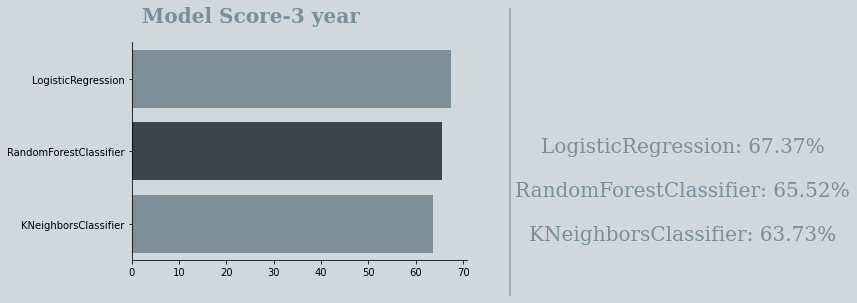

In [42]:
# 3-year trial
models_dictionary = {
    'LogisticRegression': LogisticRegression(C=100),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=20),
}

name = []
model_score = []

for k in models_dictionary.keys():
    pipeline = make_pipeline(models_dictionary[k])
    pipeline.fit(X_train_3, Y_train_3)
    prediction = pipeline.predict(X_test)
    name.append(k)
    model_score.append(round(accuracy_score(Y_test, prediction) * 100, 2))
    
fig, ax = ep.descriptive_plot(figsize=(6, 4))

sns.barplot(x=model_score, y=name, ax=ax, palette=color_palette)
sns.despine(ax=ax)

score_text = ""
for i in range(len(name)):
    score_text += f'{name[i]}: {model_score[i]}%\n\n'

fig.text(0.4, 0.95, 'Model Score-3 year',fontdict=scss.get_font_dict(fontsize=20, fontweight='bold'))
fig.text(1.4, 0.04, score_text,fontdict=scss.get_font_dict(fontsize=20))
    
plt.show()

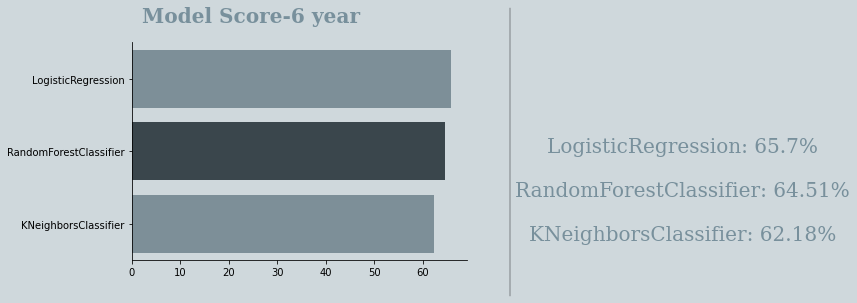

In [43]:
# 6-year trial
models_dictionary = {
    'LogisticRegression': LogisticRegression(C=100),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=20),
}

name = []
model_score = []

for k in models_dictionary.keys():
    pipeline = make_pipeline(models_dictionary[k])
    pipeline.fit(X_train_6, Y_train_6)
    prediction = pipeline.predict(X_test)
    name.append(k)
    model_score.append(round(accuracy_score(Y_test, prediction) * 100, 2))
    
fig, ax = ep.descriptive_plot(figsize=(6, 4))

sns.barplot(x=model_score, y=name, ax=ax, palette=color_palette)
sns.despine(ax=ax)

score_text = ""
for i in range(len(name)):
    score_text += f'{name[i]}: {model_score[i]}%\n\n'

fig.text(0.4, 0.95, 'Model Score-6 year',fontdict=scss.get_font_dict(fontsize=20, fontweight='bold'))
fig.text(1.4, 0.04, score_text,fontdict=scss.get_font_dict(fontsize=20))
    
plt.show()

I forgive trying 9-year trial at this time, because as I can see above, 6-year sampling decreases the performance of models compared to 3-year sampling. Also, 6-year trial already takes almost half hour for running. Instead, I will perform 2-year trial and 1-year trial to see if time length can be shortened for better performance.

In [44]:
df_data_train_2 = df_data_final.loc[(df_data_final['Year']<2018)&(df_data_final['Year']>2015),:]
X_train_2 = df_data_train_2.drop(columns=['Year','Inspection_Results'])
Y_train_2 = df_data_train_2['Inspection_Results']

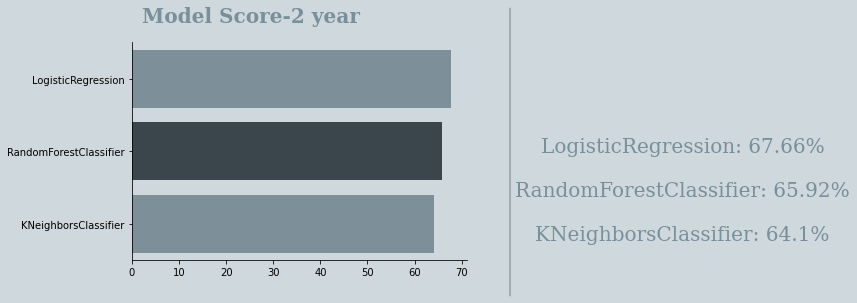

In [45]:
# 2-year trial
models_dictionary = {
    'LogisticRegression': LogisticRegression(C=100),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=20),
}

name = []
model_score = []

for k in models_dictionary.keys():
    pipeline = make_pipeline(models_dictionary[k])
    pipeline.fit(X_train_2, Y_train_2)
    prediction = pipeline.predict(X_test)
    name.append(k)
    model_score.append(round(accuracy_score(Y_test, prediction) * 100, 2))
    
fig, ax = ep.descriptive_plot(figsize=(6, 4))

sns.barplot(x=model_score, y=name, ax=ax, palette=color_palette)
sns.despine(ax=ax)

score_text = ""
for i in range(len(name)):
    score_text += f'{name[i]}: {model_score[i]}%\n\n'

fig.text(0.4, 0.95, 'Model Score-2 year',fontdict=scss.get_font_dict(fontsize=20, fontweight='bold'))
fig.text(1.4, 0.04, score_text,fontdict=scss.get_font_dict(fontsize=20))
    
plt.show()

In [46]:
df_data_train_1 = df_data_final.loc[df_data_final['Year']==2017,:]
X_train_1 = df_data_train_1.drop(columns=['Year','Inspection_Results'])
Y_train_1 = df_data_train_1['Inspection_Results']

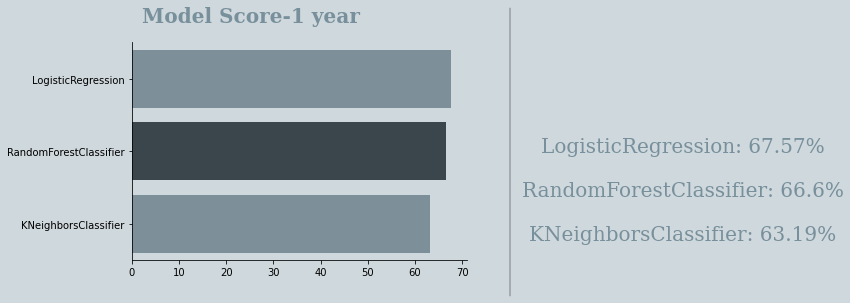

In [47]:
models_dictionary = {
    'LogisticRegression': LogisticRegression(C=100),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=20),
}

name = []
model_score = []

for k in models_dictionary.keys():
    pipeline = make_pipeline(models_dictionary[k])
    pipeline.fit(X_train_1, Y_train_1)
    prediction = pipeline.predict(X_test)
    name.append(k)
    model_score.append(round(accuracy_score(Y_test, prediction) * 100, 2))
    
fig, ax = ep.descriptive_plot(figsize=(6, 4))

sns.barplot(x=model_score, y=name, ax=ax, palette=color_palette)
sns.despine(ax=ax)

score_text = ""
for i in range(len(name)):
    score_text += f'{name[i]}: {model_score[i]}%\n\n'

fig.text(0.4, 0.95, 'Model Score-1 year',fontdict=scss.get_font_dict(fontsize=20, fontweight='bold'))
fig.text(1.4, 0.04, score_text,fontdict=scss.get_font_dict(fontsize=20))
    
plt.show()

Comparing results of diffrent modeling algorithms and time-based train sets, logistic regression with 2-year dataset has best performance.

## Predictions & Analysis

### Predict set preprocessing

In [48]:
# dataset read
df_pred_raw = pd.read_excel('Data_Test.xlsx')
df_pred_raw.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc
0,47571900570810,19-03-2014,34218,2354,2185,GROCERY STORE,17352,id-11235901,id_1890134,81864.0,CANVASS,19.0,Low,locid1145
1,19685766253655,22-11-2010,24597,13183,12516,SCHOOL,15536,id-11235901,id_1890134,81871.0,CANVASS,32.0,High,locid16450
2,37885701847801,09-06-2014,1779,26434,25220,RESTAURANT,8849,id-11235901,id_1890134,81902.0,CANVASS,NaN,High,locid12916
3,39946284936679,07-04-2010,8541,16246,16384,SCHOOL,11663,id-11235901,id_1890134,81869.0,CANVASS,NaN,High,locid7292
4,46793577796409,25-07-2010,35194,20114,19225,RESTAURANT,16286,id-11235901,id_1890134,81874.0,CANVASS RE-INSPECTION,32.0,High,locid2048


In [51]:
# similar preprocessing process as train dataset
df_pred_city = df_pred_raw.loc[(df_data_raw['City']==city)&(df_data_raw['State']==state)]
df_pred_city = df_pred_city.dropna(subset=['Type','Reason','RiskLevel'])

df_pred_assigned = df_pred_city.fillna(value={'SectionViolations': 100})
df_pred_assigned[['SectionViolations']] = df_pred_assigned[['SectionViolations']].astype('int64')
df_pred_assigned[['SectionViolations']] = df_pred_assigned[['SectionViolations']].astype('object')
df_pred_assigned = df_pred_assigned.loc[(df_pred_assigned['Date'] != '29-02-2011'),:]
df_pred_assigned = df_pred_assigned.loc[(df_pred_assigned['Date'] != '29-02-2015'),:]
df_pred_assigned['Date'] = pd.to_datetime(df_pred_assigned['Date'])
df_pred_assigned['Year'] = pd.DatetimeIndex(df_pred_assigned['Date']).year
df_pred_assigned.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Year
0,47571900570810,2014-03-19,34218,2354,2185,GROCERY STORE,17352,id-11235901,id_1890134,81864.0,CANVASS,19,Low,locid1145,2014
1,19685766253655,2010-11-22,24597,13183,12516,SCHOOL,15536,id-11235901,id_1890134,81871.0,CANVASS,32,High,locid16450,2010
2,37885701847801,2014-09-06,1779,26434,25220,RESTAURANT,8849,id-11235901,id_1890134,81902.0,CANVASS,100,High,locid12916,2014
3,39946284936679,2010-07-04,8541,16246,16384,SCHOOL,11663,id-11235901,id_1890134,81869.0,CANVASS,100,High,locid7292,2010
4,46793577796409,2010-07-25,35194,20114,19225,RESTAURANT,16286,id-11235901,id_1890134,81874.0,CANVASS RE-INSPECTION,32,High,locid2048,2010


In [53]:
df_pred_year = df_pred_assigned.loc[(df_pred_assigned['Year'] == 2018),:]
df_pred_year[(df_pred_year['Type'].isin(df_data_features['Type'].unique()))&(df_pred_year['Reason'].isin(df_data_features['Reason'].unique()))&(df_pred_year['SectionViolations'].isin(df_data_features['SectionViolations'].unique()))]
df_pred_year = df_pred_year.drop(columns=['Year'])

features = ['Type', 'Reason', 'SectionViolations', 'RiskLevel']
df_pred_features = df_pred_year.loc[:,features]
df_pred_features.describe()

,Type,Reason,SectionViolations,RiskLevel
count,4021,4021,4021,4021
unique,71,10,48,4
top,RESTAURANT,CANVASS,3,High
freq,2876,2107,1272,3209


In [54]:
df_pred_final = pd.get_dummies(df_pred_features, drop_first=True)

In [ ]:
for i in X_train_2.columns:
  if i not in df_pred_final.columns:
    df_pred_final[i] = 0

for i in df_pred_final.columns:
  if i not in X_train_2.columns:
    df_pred_final = df_pred_final.drop(columns=[i])

df_pred_final.head()

### Prediction

In [59]:
# Prediction
pipeline = make_pipeline(LogisticRegression(C=100))
pipeline.fit(X_train_2, Y_train_2)
prediction = pipeline.predict(df_pred_final)

In [61]:
# Prediction result
df_pred_year['prediction'] = prediction
df_pred_year.head()

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,prediction
20,29359873435905,2018-09-27,18733,679,556,DAYCARE (2 - 6 YEARS),10902,id-11235901,id_1890134,81858.0,CANVASS,53,High,locid13926,1
26,42454301640938,2018-07-30,18892,6711,6419,DAYCARE ABOVE AND UNDER 2 YEARS,4125,id-11235901,id_1890134,81861.0,CANVASS,100,High,locid5702,5
30,16569381551979,2018-02-13,8948,17710,16915,RESTAURANT,10897,id-11235901,id_1890134,81875.0,CANVASS,3,High,locid14626,1
35,39743863338948,2018-05-13,7739,4575,4371,GROCERY STORE,10811,id-11235901,id_1890134,81868.0,CANVASS,55,High,locid5378,1
50,32243339316854,2018-10-06,31471,2182,1991,BAKERY,6686,id-11235901,id_1890134,81904.0,CANVASS RE-INSPECTION,100,High,locid16125,1


### Analysis and conclusion

Possible reasons for "bad" performance on modeling:

1. Number of categories in one feature column(e.g. Type has 400 distinct values )
2. Missing information in "Section Violation"
3. Data input schema need to be restructured and improved.

In [63]:
# Taking top5 facility type, output pass/not pass, performing logistic regression 2-year modeling again
df_data_features.head()


,Year,Type,Reason,SectionViolations,RiskLevel,Inspection_Results
0,2010,RESTAURANT,CANVASS,33,High,4
1,2009,GROCERY STORE,COMPLAINT,33,High,4
2,2013,RESTAURANT,CANVASS,100,High,6
3,2015,RESTAURANT,CANVASS RE-INSPECTION,31,Medium,4
4,2015,RESTAURANT,COMPLAINT,30,High,4


In [70]:
df_data_type = df_data_features.groupby('Type').count()
df_data_type = df_data_type.sort_values(by='Year',ascending=False)
type_list = list(df_data_type.index[0:5])
type_list

['RESTAURANT',
 'GROCERY STORE',
 'SCHOOL',
 "CHILDREN'S SERVICES FACILITY",
 'BAKERY']

In [76]:
df_data_features = df_data_features.loc[df_data_features['Type'].isin(type_list)]
df_data_features.loc[df_data_features['Inspection_Results'].isin([1,2,3,6]), 'Inspection_Results'] = 0
df_data_features.loc[df_data_features['Inspection_Results']!=0, 'Inspection_Results'] = 1
df_data_features.head()

,Year,Type,Reason,SectionViolations,RiskLevel,Inspection_Results
0,2010,RESTAURANT,CANVASS,33,High,1
1,2009,GROCERY STORE,COMPLAINT,33,High,1
2,2013,RESTAURANT,CANVASS,100,High,0
3,2015,RESTAURANT,CANVASS RE-INSPECTION,31,Medium,1
4,2015,RESTAURANT,COMPLAINT,30,High,1


In [79]:
trans_columns = ['Type', 'Reason', 'SectionViolations', 'RiskLevel']
df_data_final = pd.get_dummies(df_data_features, columns=trans_columns, drop_first=True)
df_data_final.head()

,Year,Inspection_Results,Type_CHILDREN'S SERVICES FACILITY,Type_GROCERY STORE,Type_RESTAURANT,Type_SCHOOL,Reason_CANVASS RE-INSPECTION,Reason_COMPLAINT,Reason_COMPLAINT RE-INSPECTION,Reason_COMPLAINT-FIRE,Reason_CONSULTATION,Reason_LICENSE,Reason_LICENSE RE-INSPECTION,Reason_LICENSE-TASK FORCE,Reason_OUT OF BUSINESS,Reason_RECENT INSPECTION,Reason_SHORT FORM COMPLAINT,Reason_SHORT FORM FIRE-COMPLAINT,Reason_SUSPECTED FOOD POISONING,Reason_SUSPECTED FOOD POISONING RE-INSPECTION,Reason_TAG REMOVAL,Reason_TASK FORCE LIQUOR 1475,SectionViolations_2,SectionViolations_3,SectionViolations_4,SectionViolations_5,SectionViolations_6,SectionViolations_7,SectionViolations_8,SectionViolations_9,SectionViolations_10,SectionViolations_11,SectionViolations_12,SectionViolations_13,SectionViolations_14,SectionViolations_15,SectionViolations_16,SectionViolations_17,SectionViolations_18,SectionViolations_19,...,SectionViolations_25,SectionViolations_26,SectionViolations_27,SectionViolations_28,SectionViolations_29,SectionViolations_30,SectionViolations_31,SectionViolations_32,SectionViolations_33,SectionViolations_34,SectionViolations_35,SectionViolations_36,SectionViolations_37,SectionViolations_38,SectionViolations_39,SectionViolations_40,SectionViolations_41,SectionViolations_42,SectionViolations_43,SectionViolations_44,SectionViolations_45,SectionViolations_47,SectionViolations_48,SectionViolations_49,SectionViolations_50,SectionViolations_51,SectionViolations_52,SectionViolations_53,SectionViolations_54,SectionViolations_55,SectionViolations_56,SectionViolations_57,SectionViolations_58,SectionViolations_59,SectionViolations_60,SectionViolations_70,SectionViolations_100,RiskLevel_Low,RiskLevel_Medium,RiskLevel_Uncertain
0,2010,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2009,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2015,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2015,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [80]:
# generate reduced train set and data set
df_data_test = df_data_final.loc[(df_data_final['Year'] == 2018),:]
X_test_r = df_data_test.drop(columns=['Year','Inspection_Results'])
Y_test_r = df_data_test['Inspection_Results']

df_data_train_2 = df_data_final.loc[(df_data_final['Year']<2018)&(df_data_final['Year']>2015),:]
X_train_2_r = df_data_train_2.drop(columns=['Year','Inspection_Results'])
Y_train_2_r = df_data_train_2['Inspection_Results']


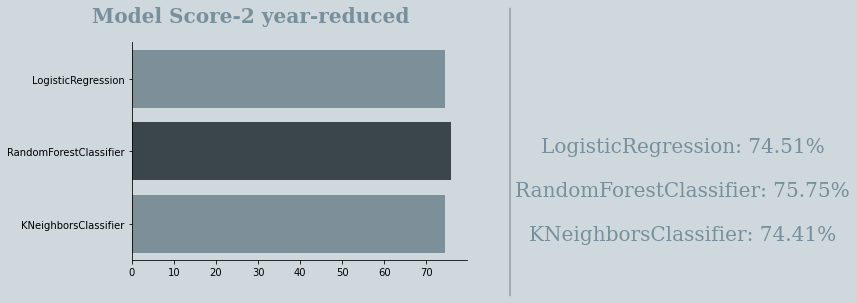

In [81]:
# reduced 2-year trial
models_dictionary = {
    'LogisticRegression': LogisticRegression(C=100),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=20),
}

name = []
model_score = []

for k in models_dictionary.keys():
    pipeline = make_pipeline(models_dictionary[k])
    pipeline.fit(X_train_2_r, Y_train_2_r)
    prediction = pipeline.predict(X_test_r)
    name.append(k)
    model_score.append(round(accuracy_score(Y_test_r, prediction) * 100, 2))
    
fig, ax = ep.descriptive_plot(figsize=(6, 4))

sns.barplot(x=model_score, y=name, ax=ax, palette=color_palette)
sns.despine(ax=ax)

score_text = ""
for i in range(len(name)):
    score_text += f'{name[i]}: {model_score[i]}%\n\n'

fig.text(0.4, 0.95, 'Model Score-2 year-reduced',fontdict=scss.get_font_dict(fontsize=20, fontweight='bold'))
fig.text(1.4, 0.04, score_text,fontdict=scss.get_font_dict(fontsize=20))
    
plt.show()